# Bike Rent Count Prediction


#### Problem Statement​ -
The objective of this Case is to Predication of bike rental count on daily based on the
environmental and seasonal settings.
The details of data attributes in the dataset are as follows -
- instant: Record index
- dteday: Date
- season: Season (1:springer, 2:summer, 3:fall, 4:winter)
- yr: Year (0: 2011, 1:2012)
- mnth: Month (1 to 12)
- hr: Hour (0 to 23)
- holiday: weather day is holiday or not (extracted fromHoliday Schedule)
- weekday: Day of the week
- workingday: If day is neither weekend nor holiday is 1, otherwise is 0.
- weathersit: (extracted fromFreemeteo)
  - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
  - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
  - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered
    clouds
  - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- temp: Normalized temperature in Celsius. The values are derived via
  (t-t_min)/(t_max-t_min),
  t_min=-8, t_max=+39 (only in hourly scale)
- atemp: Normalized feeling temperature in Celsius. The values are derived via
  (t-t_min)/(t_maxt_min), t_min=-16, t_max=+50 (only in hourly scale)
- hum: Normalized humidity. The values are divided to 100 (max)
- windspeed: Normalized wind speed. The values are divided to 67 (max)
- casual: count of casual users
- registered: count of registered users
- cnt: count of total rental bikes including both casual and registered

#### Solution​ -
The problem is of regression type so we will be building a regression model after performing required preprocessing steps on given dataset.

### Load libraries

In [201]:
import os
import pandas as pd
import numpy as np

# KNN imputation
from fancyimpute import knn

# Pandas profile report
import pandas_profiling

# Viz.
import seaborn as sns
import matplotlib.pyplot as plt

# VIF
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Error metrics
from sklearn.metrics import mean_squared_error
from sklearn import metrics

# Chi-square test
import scipy.stats as stats
from scipy.stats import chi2_contingency

# Annova test
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Scikit-learn libraries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
import xgboost as xgb

# Pickle file
from sklearn.externals import joblib 

In [202]:
# Set the directory
os.chdir("D:\Google Cloud Storage\Python Work Bench")

In [203]:
# Import the dataset
df = pd.read_csv('day.csv')
df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


## Feature Engineering

In [205]:
# Derive actual value of the features rather than normalized, binary or label encoded to make more sense out of it

#Create new columns
df['temp'] = (df['temp'] * 47) + (-8)
df['atemp'] = (df['atemp'] * 66) + (-16) 
df['windspeed'] = df['windspeed'] * 67
df['hum'] = df['hum'] * 100

df['season'] = df['season'].replace([1,2,3,4],["Spring","Summer","Fall","Winter"])
df['yr'] = df['yr'].replace([0,1],["2011","2012"])
df['holiday'] = df['holiday'].replace([0,1],["Working day","Holiday"])
df['weathersit'] = df['weathersit'].replace([1,2,3,4],["Clear","Cloudy/Mist","Rain/Snow/Fog","Heavy Rain/Snow/Fog"])

In [206]:
#Change the data types
df['weathersit'] = df['weathersit'].astype('category')
df['holiday'] = df['holiday'].astype('category')
df['yr'] = df['yr'].astype('category')
df['season'] = df['season'].astype('category')
df['workingday'] = df['workingday'].astype('category')
df['weekday'] = df['weekday'].astype('category')
df['mnth'] = df['mnth'].astype('category')

In [207]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 16 columns):
instant       731 non-null int64
dteday        731 non-null object
season        731 non-null category
yr            731 non-null category
mnth          731 non-null category
holiday       731 non-null category
weekday       731 non-null category
workingday    731 non-null category
weathersit    731 non-null category
temp          731 non-null float64
atemp         731 non-null float64
hum           731 non-null float64
windspeed     731 non-null float64
casual        731 non-null int64
registered    731 non-null int64
cnt           731 non-null int64
dtypes: category(7), float64(4), int64(4), object(1)
memory usage: 57.8+ KB


#### Initial report generated through pandas profiling to get the rough overview of complete dataset.

In [208]:
df.profile_report()

As we have seen from pandas profiling there is no missing values in the data and also all the features are normalised as given in the problem set. Therefore, this data is quiet clean so we can directly proceed with the further univariate and bivariate analysis of the data.

## Feature Selection
### 1. Correlation Analysis

    Statistically correlated: features move together directionally.
    Linear models assume feature independence.
    And if features are correlated that could introduce bias into our models.

In [209]:
num_var = ['instant', 'temp', 'atemp', 'hum', 'windspeed', 'casual', 'registered', 'cnt']

cat_var = ['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit']

In [210]:
df[cat_var].describe()

,season,yr,mnth,holiday,weekday,workingday,weathersit
count,731,731,731,731,731,731,731
unique,4,2,12,2,7,2,3
top,Fall,2012,12,Working day,6,1,Clear
freq,188,366,62,710,105,500,463


In [211]:
df[num_var].describe()

,instant,temp,atemp,hum,windspeed,casual,registered,cnt
count,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000
mean,366.000000,15.283085,15.307363,62.789406,12.762576,848.176471,3656.172367,4504.348837
std,211.165812,8.603397,10.755438,14.242910,5.192357,686.622488,1560.256377,1937.211452
min,1.000000,-5.220871,-10.781406,0.000000,1.500244,2.000000,20.000000,22.000000
25%,183.500000,7.842925,6.297605,52.000000,9.041650,315.500000,2497.000000,3152.000000
50%,366.000000,15.421651,16.124378,62.666700,12.125325,713.000000,3662.000000,4548.000000
75%,548.500000,22.804575,24.167732,73.020850,15.625371,1096.000000,4776.500000,5956.000000
max,731.000000,32.498349,39.499136,97.250000,34.000021,3410.000000,6946.000000,8714.000000


In [212]:
df_corr = df.loc[:, num_var].corr()
df_corr

,instant,temp,atemp,hum,windspeed,casual,registered,cnt
instant,1.000000,0.150580,0.152638,0.016375,-0.112620,0.275255,0.659623,0.628830
temp,0.150580,1.000000,0.991702,0.126963,-0.157944,0.543285,0.540012,0.627494
atemp,0.152638,0.991702,1.000000,0.139988,-0.183643,0.543864,0.544192,0.631066
hum,0.016375,0.126963,0.139988,1.000000,-0.248489,-0.077008,-0.091089,-0.100659
windspeed,-0.112620,-0.157944,-0.183643,-0.248489,1.000000,-0.167613,-0.217449,-0.234545
casual,0.275255,0.543285,0.543864,-0.077008,-0.167613,1.000000,0.395282,0.672804
registered,0.659623,0.540012,0.544192,-0.091089,-0.217449,0.395282,1.000000,0.945517
cnt,0.628830,0.627494,0.631066,-0.100659,-0.234545,0.672804,0.945517,1.000000


-  We will plot a Heatmap of correlation whereas, correlation measures how strongly 2 quantities are related to each other.

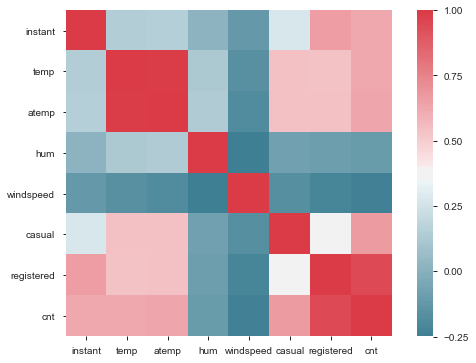

In [213]:
#Set the width and height of the plot
f, ax = plt.subplots(figsize = (9, 6))

#Plot heat map using seaborn library
sns.heatmap(df_corr, mask=np.zeros_like(df_corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)
# plt.savefig('correlation1.png')

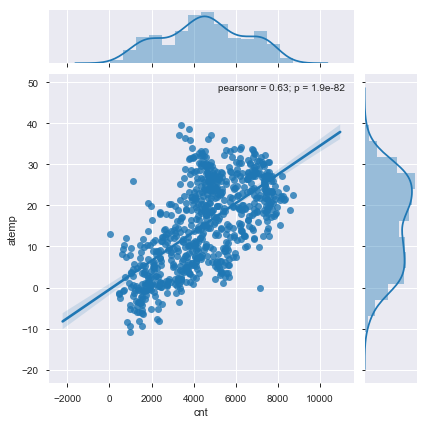

In [214]:
_ = sns.jointplot(x = 'cnt',y = 'atemp',data = df,kind = 'reg')
_.annotate(stats.pearsonr)
# plt.savefig('jointct.png')
plt.show()

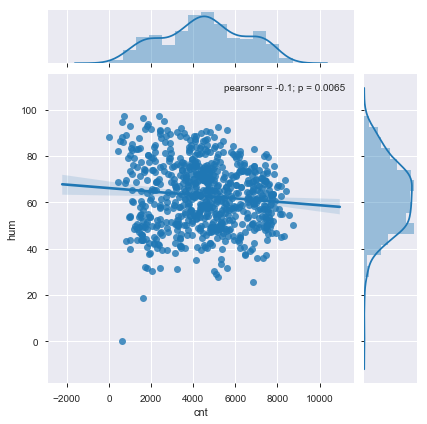

In [215]:
_ = sns.jointplot(x = 'cnt',y = 'hum',data = df,kind = 'reg')
_.annotate(stats.pearsonr)
# plt.savefig('jointct.png')
plt.show()

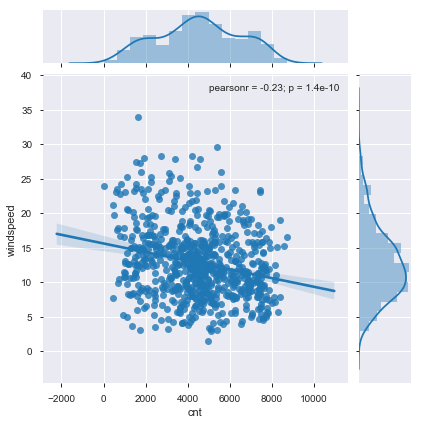

In [216]:
_ = sns.jointplot(x = 'cnt',y = 'windspeed',data = df,kind = 'reg')
_.annotate(stats.pearsonr)
# plt.savefig('jointct.png')
plt.show()

### 2. Chi-square Test

-  Hypothesis testing :
    -  Null Hypothesis: 2 variables are independent.
    -  Alternate Hypothesis: 2 variables are not independent.
-  If p-value is less than 0.05 then we reject the null hypothesis saying that 2 variables are dependent.
-  And if p-value is greater than 0.05 then we accept the null hypothesis saying that 2 variables are independent. 
-  There should be no dependencies between Independent variables.
-  So we will remove that variable whose p-value with other variable is low than 0.05.
-  And we will keep that variable whose p-value with other variable is higher than 0.05

In [217]:
#loop for chi square values
for i in cat_var:
    for j in cat_var:
        if(i != j):
            chi2, p, dof, ex = chi2_contingency(pd.crosstab(df[i], df[j]))
            if(p < 0.05):
                print(i,"and",j,"are dependent on each other with",p,'----Remove')
            else:
                print(i,"and",j,"are independent on each other with",p,'----Keep')

season and yr are independent on each other with 0.9999288084245916 ----Keep
season and mnth are dependent on each other with 0.0 ----Remove
season and holiday are independent on each other with 0.6831687073042003 ----Keep
season and weekday are independent on each other with 0.9999999999988407 ----Keep
season and workingday are independent on each other with 0.8865568364019545 ----Keep
season and weathersit are dependent on each other with 0.02117930104473366 ----Remove
yr and season are independent on each other with 0.9999288084245916 ----Keep
yr and mnth are independent on each other with 0.9999999999999892 ----Keep
yr and holiday are independent on each other with 0.9949247279855291 ----Keep
yr and weekday are independent on each other with 0.9999995848511959 ----Keep
yr and workingday are independent on each other with 0.9799434134248637 ----Keep
yr and weathersit are independent on each other with 0.12737941480418666 ----Keep
mnth and season are dependent on each other with 0.0 

### 3. Analysis of Variance(Anova) Test
-  It is carried out to compare between each groups in a categorical variable.
-  ANOVA only let us know the means for different groups are same or not. It doesn’t help us identify which mean is different.
-  Hypothesis testing :
    -  Null Hypothesis: mean of all categories in a variable are same.
    -  Alternate Hypothesis: mean of at least one category in a variable is different.
-  If p-value is less than 0.05 then we reject the null hypothesis.
-  And if p-value is greater than 0.05 then we accept the null hypothesis.

In [218]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 16 columns):
instant       731 non-null int64
dteday        731 non-null object
season        731 non-null category
yr            731 non-null category
mnth          731 non-null category
holiday       731 non-null category
weekday       731 non-null category
workingday    731 non-null category
weathersit    731 non-null category
temp          731 non-null float64
atemp         731 non-null float64
hum           731 non-null float64
windspeed     731 non-null float64
casual        731 non-null int64
registered    731 non-null int64
cnt           731 non-null int64
dtypes: category(7), float64(4), int64(4), object(1)
memory usage: 57.8+ KB


In [219]:
#ANOVA _1)+C(passenger_count_2)+C(passenger_count_3)+C(passenger_count_4)+C(passenger_count_5)+C(passenger_count_6)
model = ols('cnt ~ season+yr+mnth+holiday+weekday+workingday+weathersit',data=df).fit()
                
aov_table = sm.stats.anova_lm(model)
aov_table

,df,sum_sq,mean_sq,F,PR(>F)
season,3.0,9.505959e+08,3.168653e+08,436.233994,2.986008e-160
yr,1.0,8.840083e+08,8.840083e+08,1217.029660,9.065230e-156
mnth,11.0,1.873116e+08,1.702833e+07,23.443199,2.941086e-41
holiday,1.0,3.306975e+06,3.306975e+06,4.552770,3.320958e-02
weekday,6.0,1.583906e+07,2.639843e+06,3.634319,1.468641e-03
workingday,1.0,1.064567e+05,1.064567e+05,0.146561,7.019591e-01
weathersit,2.0,1.856074e+08,9.280368e+07,127.764457,4.388846e-48
Residual,706.0,5.128140e+08,7.263654e+05,NaN,NaN


## Wrapper for Feature Selection
In this the best subset of feature is selected, over all possible feature subsets. For example, if a dataset contains 4 features, the algorithm will evaluate all the feature combinations(15) as follows:

Combination Formula= n!/(r!(n-r)!) where r objects taken from set of n object.

- All possible combinations of 1 feature. Out of 4 features 1 feature can be selected in 4 different ways.
- All possible combinations of 2 features. Out of 4 features 2 features can be selected in 6 different ways.
- All possible combinations of 3 features. Out of 4 features 3 features can be selected in 4 different ways.
- All possible combinations of 4 features. Out of 4 features 4 features can be selected in 1 way.
  Total features= 4+6+4+1=15

### 1. Create dummies for categorical variables

In [220]:
#Creating dummies for each variable in passenger_count and merging dummies dataframe to both train and test dataframe
temp = pd.get_dummies(df['season'], prefix = 'season_', drop_first = True)
df = df.join(temp)
temp = pd.get_dummies(df['yr'], prefix = 'yr_', drop_first = True)
df = df.join(temp)
temp = pd.get_dummies(df['mnth'], prefix = 'mnth_', drop_first = True)
df = df.join(temp)
temp = pd.get_dummies(df['weekday'], prefix = 'day_', drop_first = True)
df = df.join(temp)
temp = pd.get_dummies(df['workingday'], prefix = 'workday_', drop_first = True)
df = df.join(temp)
temp = pd.get_dummies(df['weathersit'], prefix = 'weathsit_', drop_first = True)
df = df.join(temp)

In [221]:
# Drop the redundant categorical and other columns
df.drop(['instant', 'dteday', 'season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit', 'casual', 'registered'], axis = 1, inplace = True)

In [222]:
# Rearranging columns position (Edit before running)
df = df[['temp', 'atemp', 'hum', 'windspeed',
       'season__Spring', 'season__Summer', 'season__Winter', 'yr__2012',
       'mnth__2', 'mnth__3', 'mnth__4', 'mnth__5', 'mnth__6', 'mnth__7',
       'mnth__8', 'mnth__9', 'mnth__10', 'mnth__11', 'mnth__12', 'day__1',
       'day__2', 'day__3', 'day__4', 'day__5', 'day__6', 'workday__1',
       'weathsit__Cloudy/Mist', 'weathsit__Rain/Snow/Fog', 'cnt']]

In [224]:
X = df.iloc[:, :-1].values
y = df['cnt']

### 2. Backward Feature Seletion

In [225]:
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from sklearn.ensemble import RandomForestRegressor
#k_features=10 (It will get top 10 features best suited for prediction)
#forward=False (Backward feature selection model)
#verbose=2 (It will show details output as shown below.)
#cv=5 (Kfold cross valiation: it will split the training set in 5 set and 4 will be using for training the model and 1 will using as validation)
#n_jobs=-1 (Number of cores it will use for execution.-1 means it will use all the cores of CPU for execution.)
#scoring='r2'(R-squared is a statistical measure of how close the data are to the fitted regression line)
backwardModel=sfs(RandomForestRegressor(),k_features=10,forward=False,verbose=2,cv=5,n_jobs=-1,scoring='r2')
#We will convert our training data into numpy array. If we will not convert it, model is not able to read some of the column names. 
backwardModel.fit(np.array(X),y)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 out of  28 | elapsed:    3.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  28 out of  28 | elapsed:    3.2s finished

[2019-10-20 20:47:10] Features: 27/10 -- score: 0.3115425452608491[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:    0.7s finished

[2019-10-20 20:47:11] Features: 26/10 -- score: 0.35113359778154296[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 out of  26 | elapsed:    0.7s finished

[2019-10-20 20:47:12] Features: 25/10 -- score: 0.29556094710046354[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  23 out of  25 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    0.7s finished

[2019-10-20 20:47:13] Features: 24/10 -- score

SequentialFeatureSelector(clone_estimator=True, cv=5,
                          estimator=RandomForestRegressor(bootstrap=True,
                                                          criterion='mse',
                                                          max_depth=None,
                                                          max_features='auto',
                                                          max_leaf_nodes=None,
                                                          min_impurity_decrease=0.0,
                                                          min_impurity_split=None,
                                                          min_samples_leaf=1,
                                                          min_samples_split=2,
                                                          min_weight_fraction_leaf=0.0,
                                                          n_estimators='warn',
                                                          n_jobs=None,
  

In [226]:
#Get the selected feature index.
backwardModel.k_feature_idx_

(0, 2, 3, 4, 6, 7, 9, 10, 12, 15)

In [227]:
#Get the column name for the selected feature.
df.columns[list(backwardModel.k_feature_idx_)]

Index(['temp', 'hum', 'windspeed', 'season__Spring', 'season__Winter',
       'yr__2012', 'mnth__3', 'mnth__4', 'mnth__6', 'mnth__9'],
      dtype='object')

### 3. Exhaustive Feature Selection

In [228]:
from mlxtend.feature_selection import ExhaustiveFeatureSelector as efs
#min_features=1 (minimum number of feature)
#max_features=5 (maximum number of feature)
#n_jobs=-1 (Number of cores it will use for execution.-1 means it will use all the cores of CPU for execution.)
#scoring='r2'(R-squared is a statistical measure of how close the data are to the fitted regression line)
emodel=efs(RandomForestRegressor(),min_features=1,max_features=5,scoring='r2',n_jobs=-1)
#Lets take only 10 features which we got from backward feature selection.
miniData=df[df.columns[list(backwardModel.k_feature_idx_)]]

emodel.fit(np.array(miniData),y)
#If you see below the model creates 637 feature combinations from 10 features.Thats why its computationally very expensive.

Features: 637/637

ExhaustiveFeatureSelector(clone_estimator=True, cv=5,
                          estimator=RandomForestRegressor(bootstrap=True,
                                                          criterion='mse',
                                                          max_depth=None,
                                                          max_features='auto',
                                                          max_leaf_nodes=None,
                                                          min_impurity_decrease=0.0,
                                                          min_impurity_split=None,
                                                          min_samples_leaf=1,
                                                          min_samples_split=2,
                                                          min_weight_fraction_leaf=0.0,
                                                          n_estimators='warn',
                                                          n_jobs=None,
  

In [229]:
#Get the selected feature index.
emodel.best_idx_

(0, 1, 2, 3, 5)

In [230]:
#Get the column name for the selected feature.
miniData.columns[list(emodel.best_idx_)]

Index(['temp', 'hum', 'windspeed', 'season__Spring', 'yr__2012'], dtype='object')

In [231]:
miniData[['temp', 'hum', 'windspeed', 'season__Spring', 'yr__2012']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 5 columns):
temp              731 non-null float64
hum               731 non-null float64
windspeed         731 non-null float64
season__Spring    731 non-null uint8
yr__2012          731 non-null uint8
dtypes: float64(3), uint8(2)
memory usage: 18.6 KB


# Modelling and parameter tuning using `GridSearchCV` and 
# `RandomizedSearchCV`
Allows you to define a **grid of parameters** that will be **searched** using K-fold cross-validation

### Functions to generate error scores for various error metrics

In [233]:
def rmsle(y,y_):
    log1 = np.nan_to_num(np.array([np.log(v + 1) for v in y]))
    log2 = np.nan_to_num(np.array([np.log(v + 1) for v in y_]))
    calc = (log1 - log2) ** 2
    return np.sqrt(np.mean(calc))
def scores(y, y_):
    print('r square  ', metrics.r2_score(y, y_))
    print('Adjusted r square:{}'.format(1 - (1-metrics.r2_score(y, y_))*(len(y)-1)/(len(y)-X.shape[1]-1)))
    print('MAPE:{}'.format(np.mean(np.abs((y - y_) / y))*100))
    print('MSE:', metrics.mean_squared_error(y, y_))
    print('RMSE:', np.sqrt(metrics.mean_squared_error(y, y_))) 
def test_scores(model):
    print('<<<------------------- Training Data Score --------------------->')
    print()
    #Predicting result on Training data
    y_pred = model.predict(X)
    scores(y,y_pred)
    print('RMSLE:',rmsle(y,y_pred))
#     print()
#     print('<<<------------------- Test Data Score --------------------->')
#     print()
#     # Evaluating on Test Set
#     y_pred = model.predict(X_test)
#     scores(y_test,y_pred)
#     print('RMSLE:',rmsle(y_test,y_pred))

### Splitting the dataset into feature matrix and label and scaling the label

X : matrix of features
and y : label/target variable

In [238]:
# Normalizing the label as features are already normalized
# df['cnt'] = (df['cnt'] - min(df['cnt']))/(max(df['cnt']) - min(df['cnt']))

X = df[['temp', 'hum', 'windspeed', 'season__Spring', 'yr__2012']].values
y = df['cnt'].values

print(X.shape)
print(y.shape)

(731, 5)
(731,)


## Multiple Linear Regression

In [239]:
# Setup the parameters and distributions to sample from: param_dist
param_dist = {'copy_X':[True, False],
          'fit_intercept':[True,False]}
# Instantiate a Decision reg classifier: reg
reg = LinearRegression()

# Instantiate the gridSearchCV object: reg_cv
reg_cv = GridSearchCV(reg, param_dist, cv=5,scoring='r2')

# Fit it to the data
reg_cv.fit(X, y)

# Print the tuned parameters and score
print("Tuned Decision reg Parameters: {}".format(reg_cv.best_params_))
print("Best score is {}".format(reg_cv.best_score_))

Tuned Decision reg Parameters: {'copy_X': True, 'fit_intercept': True}
Best score is 0.29475338344113083


In [240]:
# Instantiate a Linear regressor: mlr
mlr = LinearRegression(copy_X = True, fit_intercept = True)

# Fit the regressor to the data
mlr.fit(X, y)

test_scores(mlr)

<<<------------------- Training Data Score --------------------->

r square   0.787113908373285
Adjusted r square:0.7856457284310318
MAPE:47.78922895816826
MSE: 797823.5054525885
RMSE: 893.2096648898222
RMSLE: 0.3350579100397971


In [241]:
y_diff = y - y_pred
y_diff = pd.DataFrame(y_diff)

for i in range(y_diff.shape[0]):
    if (y_diff.iloc[i, 0] < -1):
        y_diff.iloc[i, 0] = y_diff.iloc[i, 0] * -1
        
y_diff.describe()       

,0
count,731.000000
mean,291.352235
std,250.836739
min,-0.562012
25%,98.366272
50%,229.220703
75%,421.994751
max,1603.213623


## Ridge Regression

In [242]:
# Setup the parameters and distributions to sample from: param_dist
param_dist = {'alpha':np.logspace(-4, 0, 50),
          'normalize':[True,False],
             'max_iter':range(500,5000,500)}
# Instantiate a Decision ridge classifier: ridge
ridge = Ridge()

# Instantiate the gridSearchCV object: ridge_cv
ridge_cv = GridSearchCV(ridge, param_dist, cv=5,scoring='r2', n_jobs = -1)

# Fit it to the data
ridge_cv.fit(X, y)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='warn', n_jobs=-1,
             param_grid={'alpha': array([1.00000000e-04, 1.20679264e-04, 1.45634848e-04, 1.75751062e-04,
       2.12095089e-04, 2.55954792e-04, 3.08884360e-04, 3.72759372e-04,
       4....
       8.68511374e-02, 1.04811313e-01, 1.26485522e-01, 1.52641797e-01,
       1.84206997e-01, 2.22299648e-01, 2.68269580e-01, 3.23745754e-01,
       3.90693994e-01, 4.71486636e-01, 5.68986603e-01, 6.86648845e-01,
       8.28642773e-01, 1.00000000e+00]),
                         'max_iter': range(500, 5000, 500),
                         'normalize': [True, False]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='r2', verbose=0)

In [243]:
# Print the tuned parameters and score
print("Tuned Decision ridge Parameters: {}".format(ridge_cv.best_params_))
print("Best score is {}".format(ridge_cv.best_score_))

Tuned Decision ridge Parameters: {'alpha': 0.08685113737513521, 'max_iter': 500, 'normalize': True}
Best score is 0.31637635257842595


In [247]:
# Instantiate a ridge regressor: ridge
ridge = Ridge(alpha=0.08685113737513521, normalize=True, max_iter = 500)

# Fit the regressor to the data
ridge.fit(X, y)

test_scores(ridge)

<<<------------------- Training Data Score --------------------->

r square   0.7839186311408198
Adjusted r square:0.7824284148038599
MAPE:48.33889131924226
MSE: 809798.3003441601
RMSE: 899.8879376589954
RMSLE: 0.3332543172450187


In [245]:
y_pred = ridge.predict(X)
y_diff = y - y_pred
y_diff = pd.DataFrame(y_diff)

for i in range(y_diff.shape[0]):
    if (y_diff.iloc[i, 0] < -1):
        y_diff.iloc[i, 0] = y_diff.iloc[i, 0] * -1
        
y_diff.describe()  

,0
count,731.000000
mean,669.155172
std,599.136822
min,1.431341
25%,251.429709
50%,504.791089
75%,904.605682
max,4343.811491


## Lasso Regression

In [248]:
# Setup the parameters and distributions to sample from: param_dist
param_dist = {'alpha':np.logspace(-4, 0, 50),
          'normalize':[True,False],
             'max_iter':range(500,5000,500)}
# Instantiate a Decision lasso classifier: lasso
lasso = Lasso()

# Instantiate the gridSearchCV object: lasso_cv
lasso_cv = GridSearchCV(lasso, param_dist, cv=5,scoring='r2', n_jobs = -1)

# Fit it to the data
lasso_cv.fit(X, y)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'alpha': array([1.00000000e-04, 1.20679264e-04, 1.45634848e-04, 1.75751062e-04,
       2.12095...
       8.68511374e-02, 1.04811313e-01, 1.26485522e-01, 1.52641797e-01,
       1.84206997e-01, 2.22299648e-01, 2.68269580e-01, 3.23745754e-01,
       3.90693994e-01, 4.71486636e-01, 5.68986603e-01, 6.86648845e-01,
       8.28642773e-01, 1.00000000e+00]),
                         'max_iter': range(500, 5000, 500),
                         'normalize': [True, False]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='r2', verbose=0)

In [249]:
# Print the tuned parameters and score
print("Tuned Decision lasso Parameters: {}".format(lasso_cv.best_params_))
print("Best score is {}".format(lasso_cv.best_score_))

Tuned Decision lasso Parameters: {'alpha': 1.0, 'max_iter': 500, 'normalize': True}
Best score is 0.3049290067509672


In [250]:
# Instantiate a lasso regressor: lasso
lasso = Lasso(alpha=1, normalize=True,max_iter = 500)

# Fit the regressor to the data
lasso.fit(X,y)

test_scores(lasso)

<<<------------------- Training Data Score --------------------->

r square   0.7862234320496719
Adjusted r square:0.7847491108913938
MAPE:48.55606062180153
MSE: 801160.7029961144
RMSE: 895.0758085190965
RMSLE: 0.33294440827989824


In [251]:
y_pred = lasso.predict(X)
y_diff = y - y_pred
y_diff = pd.DataFrame(y_diff)

for i in range(y_diff.shape[0]):
    if (y_diff.iloc[i, 0] < -1):
        y_diff.iloc[i, 0] = y_diff.iloc[i, 0] * -1
        
y_diff.describe()       

,0
count,731.000000
mean,666.600594
std,597.740014
min,0.298015
25%,241.299807
50%,509.629883
75%,880.984923
max,4420.257184


## Decision Tree Regressor

In [252]:
# Setup the parameters and distributions to sample from: param_dist
param_dist = {'max_depth': range(2,16,2),
              'min_samples_split': range(2,16,2)}

# Instantiate a Decision Tree classifier: tree
tree = DecisionTreeRegressor()

# Instantiate the gridSearchCV object: tree_cv
tree_cv = GridSearchCV(tree, param_dist, cv=5, scoring = 'r2')

# Fit it to the data
tree_cv.fit(X, y)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=DecisionTreeRegressor(criterion='mse', max_depth=None,
                                             max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             presort=False, random_state=None,
                                             splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'max_depth': range(2, 16, 2),
                         'min_samples_split': range(2, 16, 2)},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scor

In [253]:
# Print the tuned parameters and score
print("Tuned Decision Tree Parameters: {}".format(tree_cv.best_params_))
print("Best score is {}".format(tree_cv.best_score_))

Tuned Decision Tree Parameters: {'max_depth': 8, 'min_samples_split': 10}
Best score is -0.10579276243716404


[0.47919808 0.0845708  0.04055801 0.07867256 0.31700055]


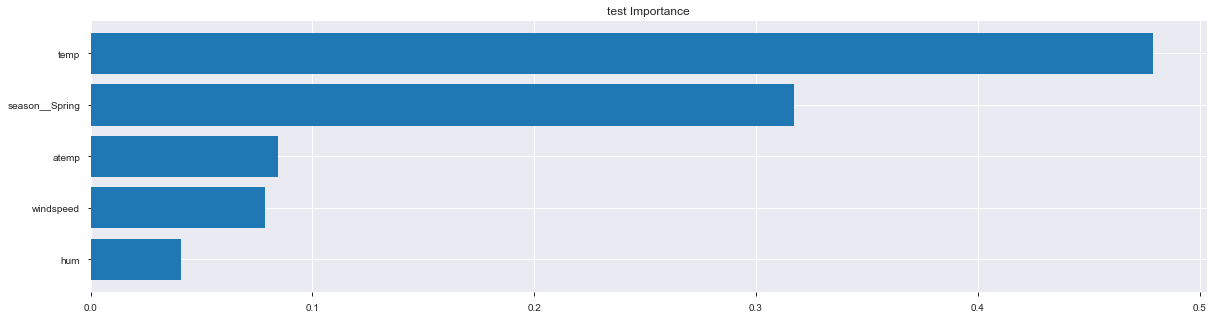

<<<------------------- Training Data Score --------------------->

r square   0.9215437166066628
Adjusted r square:0.921002638790157
MAPE:12.018941213471448
MSE: 294027.038419259
RMSE: 542.2426010737804
RMSLE: 0.17550586873561252


In [254]:
# Instantiate a tree regressor: tree
tree = DecisionTreeRegressor(max_depth= 8, min_samples_split = 10)

# Fit the regressor to the data
tree.fit(X, y)

# Compute and print the coefficients
tree_features = tree.feature_importances_
print(tree_features)

# Sort test importances in descending order
indices = np.argsort(tree_features)[::1]

# Rearrange test names so they match the sorted test importances
names = [df.columns[i] for i in indices]

# Creating plot
fig = plt.figure(figsize=(20, 5))
plt.title("test Importance")

# Add horizontal bars
plt.barh(range(pd.DataFrame(X).shape[1]),tree_features[indices],align = 'center')
plt.yticks(range(pd.DataFrame(X).shape[1]), names)
plt.savefig('tree test importance')
plt.show()
# Make predictions and cal error
test_scores(tree)

## Random Forest

In [255]:
# Create the random grid
random_grid = {'n_estimators': range(100,500,100),
               'max_depth': range(5,20,1),
               'min_samples_leaf':range(2,5,1),
              'max_features':['auto','sqrt','log2'],
              'bootstrap': [True, False],
              'min_samples_split': range(2,5,1)}
# Instantiate a Decision Forest classifier: Forest
Forest = RandomForestRegressor()

# Instantiate the gridSearchCV object: Forest_cv
Forest_cv = RandomizedSearchCV(Forest, random_grid, cv=5, n_jobs = -1, scoring = 'r2')

# Fit it to the data
Forest_cv.fit(X, y)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators='warn',
                                                   n_jobs=None, oob_score=False,
                                                   random_sta...


In [256]:
# Print the tuned parameters and score
print("Tuned Random Forest Parameters: {}".format(Forest_cv.best_params_))
print("Best score is {}".format(Forest_cv.best_score_))

Tuned Random Forest Parameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'max_depth': 14, 'bootstrap': True}
Best score is 0.39244688672490313


#### Using the best parameters to make predictions

[0.38291188 0.09385689 0.06141228 0.1593941  0.30242485]


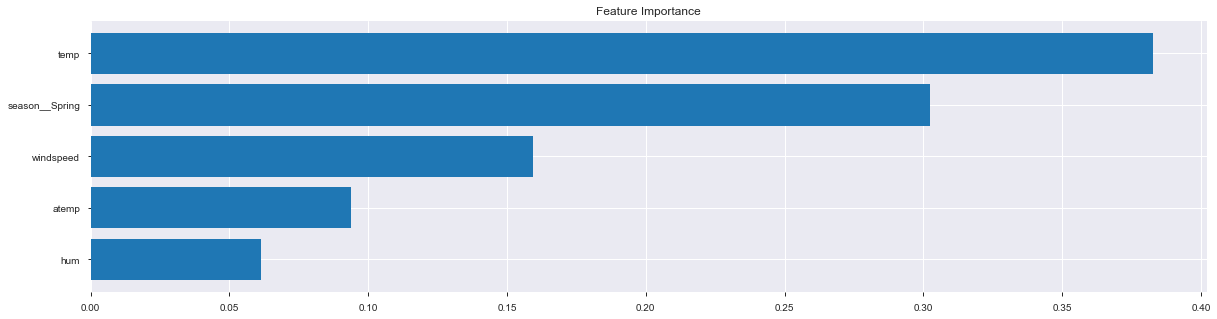

<<<------------------- Training Data Score --------------------->

r square   0.930916728731136
Adjusted r square:0.9304402923775575
MAPE:31.163042318100015
MSE: 258900.22796087948
RMSE: 508.8223933366922
RMSLE: 0.2589454769225807


In [257]:
# Instantiate a Forest regressor: Forest
Forest = RandomForestRegressor(n_estimators = 100, min_samples_split = 2, min_samples_leaf = 3, 
                               max_features = 'sqrt', max_depth = 14, bootstrap = True)
# Fit the regressor to the data
Forest.fit(X,y)

# Compute and print the coefficients
Forest_features = Forest.feature_importances_
print(Forest_features)

# Sort feature importances in descending order
indices = np.argsort(Forest_features)[::1]

# Rearrange feature names so they match the sorted feature importances
names = [df.columns[i] for i in indices]

# Creating plot
fig = plt.figure(figsize=(20,5))
plt.title("Feature Importance")

# Add horizontal bars
plt.barh(range(pd.DataFrame(X).shape[1]),Forest_features[indices],align = 'center')
plt.yticks(range(pd.DataFrame(X).shape[1]), names)
plt.savefig('Random forest feature importance')
plt.show()# Make predictions
test_scores(Forest)

In [258]:
y_pred = Forest.predict(X)
y_diff = y - y_pred
y_diff = pd.DataFrame(y_diff)

for i in range(y_diff.shape[0]):
    if (y_diff.iloc[i, 0] < -1):
        y_diff.iloc[i, 0] = y_diff.iloc[i, 0] * -1
        
y_diff.describe()    

,0
count,731.000000
mean,369.575867
std,349.973513
min,1.243117
25%,134.447911
50%,262.662852
75%,517.657473
max,3011.258913


In [259]:
# Boosting
# Create the random grid
para = {'n_estimators': range(100,500,100),
               'max_depth': range(3,10,1),
        'reg_alpha':np.logspace(-4, 0, 50),
        'subsample': np.arange(0.1,1,0.2),
        'colsample_bytree': np.arange(0.1,1,0.2),
        'colsample_bylevel': np.arange(0.1,1,0.2),
        'colsample_bynode': np.arange(0.1,1,0.2),
       'learning_rate': np.arange(.05, 1, .05)}
# Instantiate a Decision Forest classifier: Forest
Xgb = XGBRegressor()

# Instantiate the gridSearchCV object: Forest_cv
xgb_cv = RandomizedSearchCV(Xgb, para, cv=5, scoring = 'r2')

# Fit it to the data
xgb_cv.fit(X, y)

[20:54:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:54:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:54:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:54:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:54:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:54:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:54:47] WARNI

[20:54:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1, gamma=0,
                                          importance_type='gain',
                                          learning_rate=0.1, max_delta_step=0,
                                          max_depth=3, min_child_weight=1,
                                          missing=None, n_estimators=100,
                                          n_jobs=1, nthread=None,
                                          objective='reg:linear',
                                          random_st...
       8.68511374e-02, 1.04811313e-01, 1.26485522e-01, 1.52641797e-01,
       1.84206997e-01, 2.22299648e-01, 2.68269580e-01, 3.23745754e-01,
       3.90693994e-01, 4.71486636e-01, 5.689866

In [260]:
# Print the tuned parameters and score
print("Tuned Xgboost Parameters: {}".format(xgb_cv.best_params_))
print("Best score is {}".format(xgb_cv.best_score_))

Tuned Xgboost Parameters: {'subsample': 0.5000000000000001, 'reg_alpha': 0.32374575428176433, 'n_estimators': 300, 'max_depth': 4, 'learning_rate': 0.35000000000000003, 'colsample_bytree': 0.7000000000000001, 'colsample_bynode': 0.1, 'colsample_bylevel': 0.7000000000000001}
Best score is 0.33167869325982574


[20:56:22] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0.19554533 0.12393151 0.0866812  0.21088122 0.3829607 ]


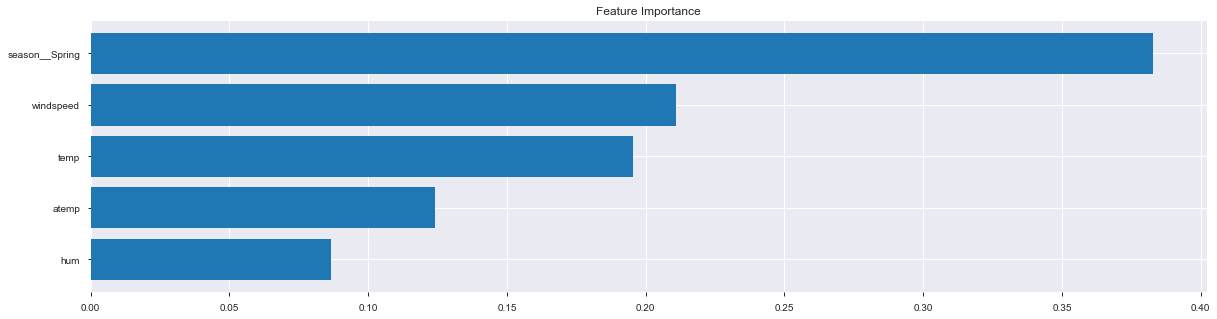

<<<------------------- Training Data Score --------------------->

r square   0.9872439286517363
Adjusted r square:0.9871559557458862
MAPE:5.883253608623021
MSE: 47805.34736257024
RMSE: 218.64433988230803
RMSLE: 0.10696627237705397


In [261]:
# Instantiate a xgb regressor: xgb
Xgb = XGBRegressor(subsample= 0.5000000000000001, reg_alpha= 0.32374575428176433, n_estimators= 300, max_depth= 4, 
                   learning_rate=0.35000000000000003, colsample_bytree= 0.7000000000000001, colsample_bynode=0.1, 
                   colsample_bylevel=0.7000000000000001)

# Fit the regressor to the data
Xgb.fit(X, y)

# Compute and print the coefficients
xgb_features = Xgb.feature_importances_
print(xgb_features)

# Sort feature importances in descending order
indices = np.argsort(xgb_features)[::1]

# Rearrange feature names so they match the sorted feature importances
names = [df.columns[i] for i in indices]

# Creating plot
fig = plt.figure(figsize=(20, 5))
plt.title("Feature Importance")

# Add horizontal bars
plt.barh(range(pd.DataFrame(X).shape[1]),xgb_features[indices],align = 'center')
plt.yticks(range(pd.DataFrame(X).shape[1]), names)
plt.savefig(' xgb feature importance')
plt.show()# Make predictions
test_scores(Xgb)

In [192]:
y_pred = Xgb.predict(X)
y_diff = y - y_pred
y_diff = pd.DataFrame(y_diff)

for i in range(y_diff.shape[0]):
    if (y_diff.iloc[i, 0] < -1):
        y_diff.iloc[i, 0] = y_diff.iloc[i, 0] * -1
        
y_diff.describe()    

,0
count,731.000000
mean,291.352235
std,250.836739
min,-0.562012
25%,98.366272
50%,229.220703
75%,421.994751
max,1603.213623


# Final Result
-  As we can in case of XGBoost we are getting the leat RMSE, MAPE and largest Adjusted R square value. Therefor, we will use      XGBoost as ur finalised model.

-  ##### Multiple Linear Regression
   - r square   0.787113908373285
   - Adjusted r square:0.7856457284310318
   - MAPE:47.78922895816826
   - MSE: 797823.5054525885
   - RMSE: 893.2096648898222
   - RMSLE: 0.3350579100397971
-  ##### Ridge Regression
   - r square   0.7839186311408198
   - Adjusted r square:0.7824284148038599
   - MAPE:48.33889131924226
   - MSE: 809798.3003441601
   - RMSE: 899.8879376589954
   - RMSLE: 0.3332543172450187
-  ##### Lasso Regression
   - r square   0.7862234320496719
   - Adjusted r square:0.7847491108913938
   - MAPE:48.55606062180153
   - MSE: 801160.7029961144
   - RMSE: 895.0758085190965
   - RMSLE: 0.33294440827989824
-  ##### Decision Tree
   - r square   0.9215437166066628
   - Adjusted r square:0.921002638790157
   - MAPE:12.018941213471448
   - MSE: 294027.038419259
   - RMSE: 542.2426010737804
   - RMSLE: 0.17550586873561252
-  ##### Random Forest
   - r square   0.930916728731136
   - Adjusted r square:0.9304402923775575
   - MAPE:31.163042318100015
   - MSE: 258900.22796087948
   - RMSE: 508.8223933366922
   - RMSLE: 0.2589454769225807
-  ##### XGBoost
   - r square   0.9872439286517363
   - Adjusted r square:0.9871559557458862
   - MAPE:5.883253608623021
   - MSE: 47805.34736257024
   - RMSE: 218.64433988230803
   - RMSLE: 0.10696627237705397

### Save the final model as pickle file 

In [262]:
# Save the model as a pickle in a file 
joblib.dump(Xgb, 'Bike_rent_xgboost_model.pkl') 
  
# Load the model from the file 
Xgb_from_joblib = joblib.load('cab_fare_xgboost_model.pkl') 
Xgb_from_joblib

[21:01:23] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree',
             colsample_bylevel=0.9000000000000001,
             colsample_bynode=0.7000000000000001,
             colsample_bytree=0.7000000000000001, gamma=0,
             importance_type='gain', learning_rate=0.05, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=nan, n_estimators=200,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0.08685113737513521, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=0.1, verbosity=1)